In [1]:
!pip install tensorflow==2.15.0
!pip install keras==2.15.0


!pip install imageio
!pip install opencv-python

In [2]:
# import neccessary libraries
from keras.layers import UpSampling2D, Reshape, Activation, Conv2D, BatchNormalization, LeakyReLU, Input, Flatten, multiply, Embedding
from keras.optimizers import Adam
from keras.models import Sequential, Model
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
from keras.layers import ZeroPadding2D
from keras.layers import Concatenate


from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

import time


import cv2
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam as LegacyAdam
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.optimizers import Adam as LegacyAdam
import tensorflow as tf  


import glob
import imageio
from tensorflow.keras import layers
from IPython import display

In [3]:
# Function to load images from a directory

# Define the paths
glioma_tumor_path = "C:\\Users\\net pc\\Desktop\\Thesis Paper 3\\Brain tumor dataset\\Testing\\glioma_tumor"

# Function to load and resize images
from PIL import Image
import numpy as np
import os

def load_and_resize_images(folder_path, target_size=(64, 64)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale using 'L' mode
            img = img.resize(target_size, Image.ANTIALIAS)
            img_array = np.array(img)
            images.append(img_array)
    return np.array(images)

# Assuming glioma_tumor is the path as previously defined
glioma_tumor_images = load_and_resize_images(glioma_tumor_path)

# Now, you should be able to reshape without error
glioma_tumor_images = glioma_tumor_images.reshape(glioma_tumor_images.shape[0], 64, 64, 1).astype('float32')
glioma_tumor_images = (glioma_tumor_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

print("glioma_tumor image shape:", glioma_tumor_images.shape)


glioma_tumor image shape: (100, 64, 64, 1)


C:\Users\net pc\AppData\Local\Temp\ipykernel_6356\3728910268.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


In [4]:



glioma_tumor_images = glioma_tumor_images.reshape(glioma_tumor_images.shape[0], 64, 64, 1).astype('float32')
glioma_tumor_images = (glioma_tumor_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [5]:
BATCH_SIZE = 32 

# batch and shuffle data
glioma_tumor_images = tf.data.Dataset.from_tensor_slices(glioma_tumor_images).shuffle(len(glioma_tumor_images)).batch(BATCH_SIZE)


In [6]:
glioma_tumor_images

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)>

## Create the models

Both the generator and discriminator are defined using the Keras Sequential API

## The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

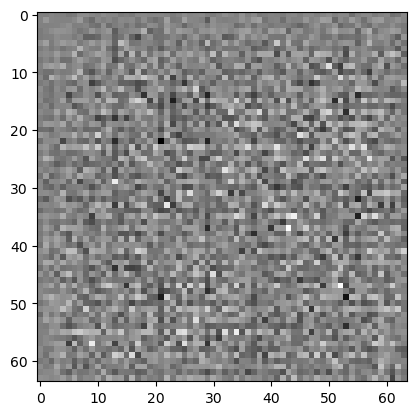

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # Fully connected layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to a 3D tensor
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    # Upsample to 16x16x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 32x32x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 64x64x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model

# Create the generator model
generator = make_generator_model()

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Generate a random noise vector
noise = tf.random.normal([1, 100])

# Generate an image using the generator
generated_image = generator(noise, training=False)

# Display the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

 the generator model's final layer now outputs tensors with a shape suitable for RGB images, specifically (64, 64, 3). When displaying the image, we adjust the normalization to map the pixel values back to the [0, 255] range and cast to uint8 for proper visualization. Note that the plt.imshow call no longer needs cmap='gray' since we are working with full-color images.

### Use the (as yet untrained) generator to create an image.

## The Discriminator
The discriminator is a CNN-based image classifier.

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model




### Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4999644]], shape=(1, 1), dtype=float32)


This code will output the decision made by the discriminator for the generated images. Positive values indicate that the discriminator perceives the images as real, while negative values indicate that the images are classified as fake.

## Define the loss and optimizers
Define loss functions and optimizers for both models.

In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In this code:

tf.keras.losses.BinaryCrossentropy is used to compute the binary cross-entropy loss.
The argument from_logits=True indicates that the input to this function are logits (i.e., the raw output of the discriminator) rather than probabilities.
This helper function will be used later to compute the loss for both the generator and discriminator during training.

## Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [11]:

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
     

In this code:

real_output and fake_output are the output predictions of the discriminator for real and fake images, respectively.

tf.ones_like(real_output) creates an array of 1s with the same shape as real_output, representing the target labels for real images.

tf.zeros_like(fake_output) creates an array of 0s with the same shape as fake_output, representing the target labels for fake images.

cross_entropy is the binary cross-entropy loss function defined earlier.

real_loss computes the binary cross-entropy loss between the real_output and the array of 1s.

fake_loss computes the binary cross-entropy loss between the fake_output and the array of 0s.

total_loss is the sum of real_loss and fake_loss, representing the overall discriminator loss.

This function will be used during training to compute the loss for the discriminator.

## Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In this code:

fake_output is the output predictions of the discriminator for the fake images generated by the generator.

tf.ones_like(fake_output) creates an array of 1s with the same shape as fake_output, representing the target labels for the discriminator (indicating that the generated images are real).

cross_entropy is the binary cross-entropy loss function defined earlier.

The function returns the binary cross-entropy loss between the fake_output and the array of 1s.
This function will be used during training to compute the loss for the generator. The goal of the generator is to minimize this loss, indicating that it successfully generated images that the discriminator classified as real.

### The discriminator and the generator optimizers are different since we are training two networks separately.

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In this code:

generator_optimizer is an instance of the Adam optimizer used to optimize the generator's weights during training.

discriminator_optimizer is an instance of the Adam optimizer used to optimize the discriminator's weights during training.

Both optimizers are initialized with a learning rate of 1e-4 (0.0001), which is a commonly used learning rate for training GANs.

These optimizers will be used during the training loop to update the weights of the generator and the discriminator in their respective steps.

## Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [15]:
EPOCHS = 10  
noise_dim = 100
num_examples_to_generate = 16  # The total number of synthetic images i want
save_interval=1000
#  will reuse this seed overtime 
# to visualize progress in the animated GIF)

seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Generate and save images

In [18]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):     
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train the model



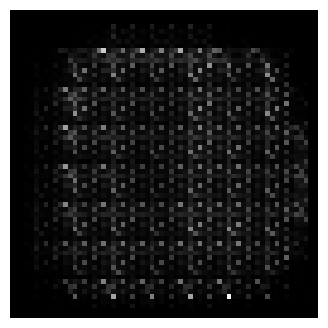

In [19]:
train(glioma_tumor_images, EPOCHS)